# Polynomial regression

In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [13]:
# Download data
stock_symbol = "TCS"
start_date = "2013-12-31"
end_date = "2023-12-30"
data = yf.download(stock_symbol, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [14]:
# target variable

data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['target'] = data['Close'].shift(-1)
data.dropna(inplace=True)


In [15]:
# Generate features
features_list = []

# Moving Average
for i in [10, 15, 25, 35]:
    col_name = 'SMA_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)

# RSI
window_length = 14
diff = data['Close'].diff(1)
gain = diff.where(diff > 0, 0)
loss = -diff.where(diff < 0, 0)
avg_gain = gain.rolling(window=window_length).mean()
avg_loss = loss.rolling(window=window_length).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))
features_list.append('RSI')

# Exponential Moving Averages (EMA)
for i in [10, 20, 50]:
    col_name = 'EMA_' + str(i)
    data[col_name] = data['Close'].ewm(span=i, adjust=False).mean()
    features_list.append(col_name)


In [16]:
# Generate train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features_list].iloc[:-1],
    data.iloc[:-1]['target'],
    test_size=0.25,
    shuffle=False
)


In [22]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:

# Feature engineering for polynomial regression
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)


In [24]:
# Build model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)


LinearRegression()

In [25]:
# Evaluate model
y_pred_train_poly = poly_model.predict(X_train_poly)
print('Model accuracy on training data:', poly_model.score(X_train_poly, y_train))

y_pred_poly = poly_model.predict(X_test_poly)
print('Model accuracy on testing data:', poly_model.score(X_test_poly, y_test))

mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)

print('Mean Squared Error (Polynomial):', mse_poly)
print('Mean Absolute Error (Polynomial):', mae_poly)


Model accuracy on training data: 0.9736164129139405
Model accuracy on testing data: 0.9585381226546082
Mean Squared Error (Polynomial): 0.4559050331949382
Mean Absolute Error (Polynomial): 0.47168497058653064


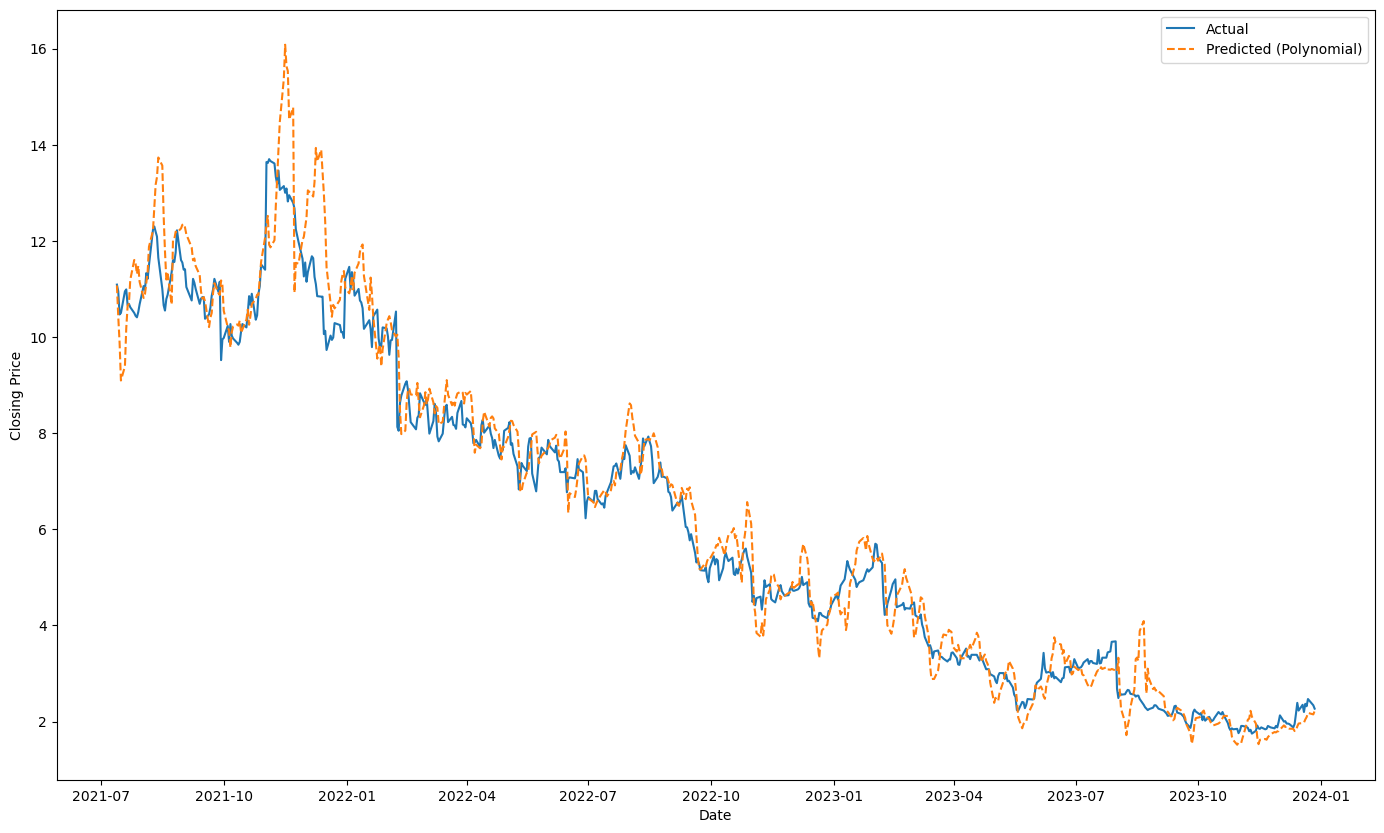

            Actual  Predicted
Date                         
2021-07-13   11.09  11.072266
2021-07-14   10.95  10.427734
2021-07-15   10.47   9.886719
2021-07-16   10.50   9.095703
2021-07-19   10.95   9.390625
...            ...        ...
2023-12-20    2.37   2.044922
2023-12-21    2.32   2.095703
2023-12-22    2.47   2.181641
2023-12-26    2.34   2.150391
2023-12-27    2.27   2.222656

[620 rows x 2 columns]


In [26]:



# Plot results
plt.figure(figsize=(17, 10))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, poly_model.predict(X_test_poly), label='Predicted (Polynomial)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

print(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_poly}))
